# Distance Distribution

### The distribution of distances between nodes is an interesting property of random graphs that is not developed as much as the concepts of clustering coefficient and degree distribution. In this report, we will create a function to generate a plot of the distribution, and use this to analyse certain graphs.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

def ddist(g):
    pwd = nx.all_pairs_shortest_path_length(g)
    pwds = []
    for d in pwd:
        pwds.extend(d[1].values())

    pwds = sorted(list(filter(lambda x: x != 0, pwds)))
    count = Counter(pwds)
    plt.bar(count.keys(), count.values())
    plt.xlabel("Distance")
    plt.ylabel("Number of pairs")
    plt.title("Distance distribution")
    plt.show()
    return


The function has been written. Thus we shall use the function on the graph of Facebook sample to obtain its distribution of pair wise distances.

## Facebook

In [2]:
gf = nx.Graph()
with open("facebook_combined.txt") as f:
    edges = f.read().split("\n")
    edges.pop()
    edges = [tuple(map(int, edge.split(" "))) for edge in edges]
gf.add_edges_from(edges)

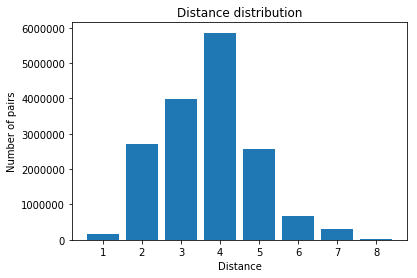

In [3]:
ddist(gf)

With the function generated, we will thus apply the function to the various graphs that we have introduced previously.

## Erdos-Renyi Model

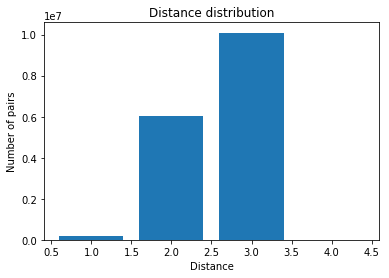

In [4]:
n = 4039
p = 88234 / (n * (n-1) / 2)

g = nx.erdos_renyi_graph(n, p)
ddist(g)

## Watts-Strogatz Model

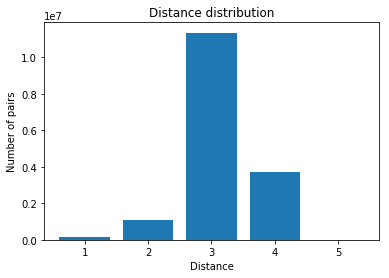

In [5]:
n = 4039
k = 44
beta = 1 - (0.6055 * (4 * (k-1)) / (3 * (k-2))) ** (1/3)

g = nx.watts_strogatz_graph(n, k, beta)
ddist(g)

## Barabasi-Albert Model

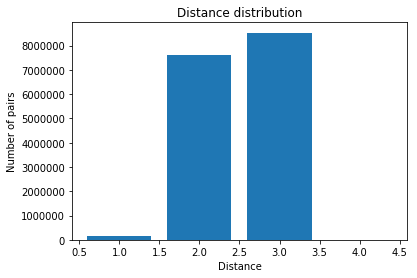

In [6]:
n = 4039
m = 22

g = nx.barabasi_albert_graph(4039, 22)
ddist(g)

## Klemm-Eguiluz Model

In [7]:
def klemm_eguiluz(n, m, mu):
    # initial condition of complete graphs with m nodes
    g = nx.complete_graph(m)
    # list used to represent whether or not a node is activated(1) or deactivated(0)
    activation = list(np.ones(m))
    
    for i in range(m, n):
        # generate list of edges which are to be randomly rewired
        mu_factor = np.random.ranf(m) < mu
        activated = [x for x in range(i) if activation[x] == 1]
        targets = set([activated[j] for j in range(m) if mu_factor[j] == 0])
        
        # Linear preferential attachment
        p_total = sum(map(g.degree, range(i)))
        p_dstr = [g.degree(node) / p_total for node in range(i)]
        
        while len(targets) < m:
            targets.add(np.random.choice(list(range(i)), p = p_dstr))
        g.add_edges_from(zip(np.full(m, i), list(targets)))
        
        # Activation and deactivation where p = a / k, and 1/a = sum of 1/k
        
        k = [g.degree(active)**-1 for active in activated]
        a = sum(k)
        p_deact = [l / a for l in k]
        deactivated = np.random.choice(activated, p = p_deact)
        activation[deactivated] = 0
        activation.append(1)
                
    return g

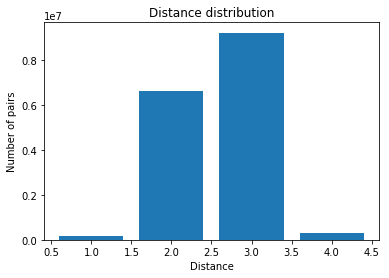

In [8]:
n = 4039
m = 22
mu = 0.09

g = klemm_eguiluz(n, m, mu)
ddist(g)

## Stochastic Block Model

In [9]:
def block(n, p1, p2, zeta = 0.5):
    groups = []

    while sum(groups) < n:
        ppln = np.random.randint(1, n * zeta)
        if ppln + sum(groups) > n:
            ppln = n - sum(groups)
        groups.append(ppln)
        
    edges = np.random.ranf([n, n])
    edges = (edges + edges.T) / 2
    targets = edges.copy()
    targets = targets < (p2*2)
    group = 0
    node = 0
    while group < len(groups):
        append = edges[node:node+groups[group], node:node+groups[group]] < p1 * 2
        targets[node:node+groups[group], node:node+groups[group]] = append
        node = node + groups[group]
        group +=1
    
    print(f"Number of clusters: {len(groups)}")
    g = nx.from_numpy_matrix(targets)
    return g


Number of clusters: 210


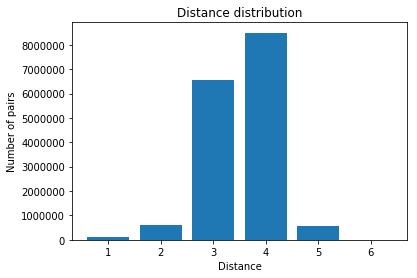

In [10]:
g = block(4039, 0.4, 0.01, zeta = 0.01)
ddist(g)

## Random Geometric Graph

In [11]:
# Function to generate random polar coordinates
def post_gen(t):
    theta, norm = np.random.ranf() * np.pi * 2, np.random.ranf()
    x, y = np.cos(theta) * norm, np.sin(theta) * norm
    return [x, y]

def geometric_graph(n, d):
    g = nx.Graph()
    posts = list(map(post_gen, range(n)))
    
    def node_add(node):
        return (node, dict(pos = posts[node]))
    
    nodes = list(map(node_add, range(n)))
    g.add_nodes_from(nodes)
    
    def edges_add(node):
    
        def distance(target):
            dist = ((posts[node][0] - posts[target][0]) ** 2 + (posts[node][1] - posts[target][1]) ** 2)**0.5
            return dist
        
        distance = np.vectorize(distance)
        dists = distance(range(n))
        targets = np.where(dists < d)[0]
        return zip(targets, np.full(len(targets), node))
    
    edges_add = np.vectorize(edges_add)
    edges = edges_add(range(n))
    for edge in edges:
        g.add_edges_from(edge)
        
    return g


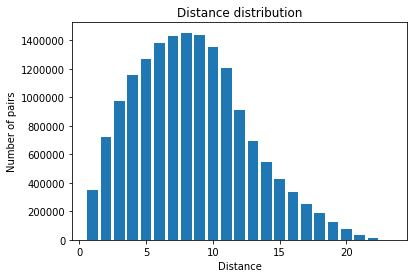

In [12]:
g = geometric_graph(4039, 0.1)
ddist(g)

## Chang-Chang Model

In [13]:
def chang_chang(n, k, phi, chi, delta):
    
    g = nx.Graph()
    
    def post_gen(irrelevant):
        theta, norm = np.random.ranf() * np.pi * 2, np.random.ranf()
        x, y = np.cos(theta) * norm, np.sin(theta) * norm
        return [x, y]
    
    clusters = [[int(i)] for i in range(chi)]
    cluster_b = [tuple(post_gen(1)) for i in clusters]
    posts = cluster_b.copy()
    
    def cluster_b_gen(node):
        return (node, dict(pos = cluster_b[node]))
    
    initial = list(map(cluster_b_gen, range(chi)))
    g.add_nodes_from(initial)
    
    def edge_initialize(node):
        target = np.random.choice(range(chi))
        return (node, target)
    
    edges_initialize = list(map(edge_initialize, range(chi)))
    g.add_edges_from(edges_initialize)
    
    for node in range(chi, n):
        pplns = list(map(len, clusters))
        ppln = list(np.array(pplns) / sum(pplns))
        cluster_add = np.random.choice(range(chi), p = ppln)
        i = cluster_add
        clusters[i].append(node)
        
        def delt_gen(node):
            delt = post_gen(1)
            delt = tuple([delt[0] / delta, delt[1] / delta])
            post = (cluster_b[i][0] + delt[0], cluster_b[i][1] + delt[1])
            posts.append(post)
            return post
        
        g.add_node(node, pos = delt_gen(node))

        def edges(k):
            
            def distance(target):
                dist = ((posts[node][0] - posts[target][0]) ** 2 + (posts[node][1] - posts[target][1]) ** 2)**0.5
                return dist
            
            def pcalc(target):
                d = distance(target)
                return ((g.degree(target)+1)**phi) / d
            
            def p_dist(targets):
                dist = np.array(list(map(pcalc, targets)))
                dist = dist / sum(dist)
                return list(dist)
            
            size_n = np.random.randint(1, k)
                
            available = list(range(0, node))
            targets = np.random.choice(available, p = p_dist(available), size = size_n, replace = False)
            edges_add = list(zip(targets, np.full(len(targets), node)))
        
            return edges_add
    
        g.add_edges_from(edges(k))

    return g

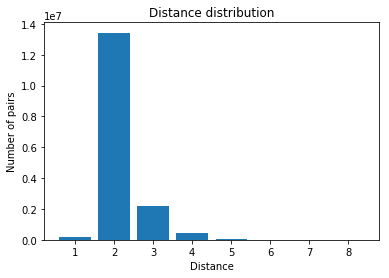

In [14]:
g = chang_chang(4039, 44, 2, 400, 20)
ddist(g)

## Deviation in distance distribution

To identify models that resemble social networks in terms of distance distribution, we will utilise the same method of least squares to quantify the deviation for every model, and thus compare these graphs.

In [25]:
gf = nx.Graph()
with open("facebook_combined.txt") as f:
    edges = f.read().split("\n")
    edges.pop()
    edges = [tuple(map(int, edge.split(" "))) for edge in edges]
gf.add_edges_from(edges)

In [39]:
def ddistf(g):
    pwd = nx.all_pairs_shortest_path_length(g)
    pwds = []
    for d in pwd:
        pwds.extend(d[1].values())

    pwds = sorted(list(filter(lambda x: x != 0, pwds)))
    countf = list(Counter(pwds).values())
    return countf

def ddd(g):
    pwd = nx.all_pairs_shortest_path_length(g)
    pwds = []
    for d in pwd:
        pwds.extend(d[1].values())

    pwds = sorted(list(filter(lambda x: x != 0, pwds)))
    count = list(Counter(pwds).values())
    diff = len(count) - len(countf)
    if diff > 0:
        countf.extend([0 for i in range(diff)])
    elif diff < 0:
        count.extend([0 for i in range(-diff)])
    res = [((count[i]-countf[i])/(4039*4038/2))**2 for i in range(len(count))]
    return np.mean(res)

countf = ddistf(gf)

In [40]:
n = 4039
p = 88234 / (n * (n-1) / 2)

g = nx.erdos_renyi_graph(n, p)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.16862349130036314


In [41]:
n = 4039
k = 44
beta = 1 - (0.6055 * (4 * (k-1)) / (3 * (k-2))) ** (1/3)

g = nx.watts_strogatz_graph(n, k, beta)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.13524226201358214


In [42]:
n = 4039
m = 22

g = nx.barabasi_albert_graph(4039, 22)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.16189461442128805


In [43]:
n = 4039
m = 22
mu = 0.09

g = klemm_eguiluz(n, m, mu)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.1663817220701705


In [44]:
g = block(4039, 0.4, 0.01, zeta = 0.01)
print(f"Mean deviation: {ddd(g)}")

Number of clusters: 204
Mean deviation: 0.04362638984423654


In [45]:
g = geometric_graph(4039, 0.1)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.031616936514583055


In [46]:
g = chang_chang(4039, 44, 2, 400, 20)
print(f"Mean deviation: {ddd(g)}")

Mean deviation: 0.10264363048765002
